# Tutorial: DataFrames with RLM

DSPy provides first-class support for pandas DataFrames in the RLM (Recursive Language Model) module. DataFrames are automatically serialized via Parquet format, preserving dtypes, and rich metadata is provided to the LLM.

> **Important**: `dspy.DataFrame` should only be used with `dspy.RLM`. Other modules like `ChainOfThought` or `Predict` will only see a string representation of the DataFrame, not the actual data. RLM provides a Python sandbox where the DataFrame is available for code execution.

Install the latest DSPy via `pip install -U dspy` and follow along.

## 1) Setup

First, let's configure DSPy with an LM and create a sample DataFrame.

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="Pydantic serializer warnings")

import dspy
import pandas as pd

# Configure your LM
lm = dspy.LM("anthropic/claude-sonnet-4-5-20250929", max_tokens=16000)
dspy.configure(lm=lm)

In [ ]:
# Create a sample DataFrame
dataframe = pd.DataFrame({
    "name": ["Alice", "Bob", "Charlie", "David", "Eve"],
    "age": [25, 30, 35, 40, 45],
    "city": ["New York", "Los Angeles", "Chicago", "Houston", "Miami"]
})

dataframe

## 2) Using `dspy.DataFrame` in Signatures

To use a DataFrame as an input field in a DSPy Signature, use the `dspy.DataFrame` type annotation. This tells Pydantic how to handle the DataFrame type.

In [ ]:
class DocWriter(dspy.Signature):
    """Write documentation for the provided data."""
    
    dataframe: dspy.DataFrame = dspy.InputField()
    documentation: str = dspy.OutputField(desc="Generated markdown documentation.")

## 3) Running RLM with DataFrames

Now we can use `dspy.RLM` to process the DataFrame. The RLM module will:

1. Serialize the DataFrame to Parquet format (preserving dtypes)
2. Provide rich metadata to the LLM (shape, columns, dtypes, sample rows)
3. Make the DataFrame available in the Python sandbox for code execution

In [ ]:
doc_writer = dspy.RLM(
    DocWriter,
    max_iterations=10,
    verbose=True
)

result = doc_writer(dataframe=dataframe)

In [ ]:
print(result.documentation)

## 4) How It Works

When you pass a DataFrame to RLM:

1. **Serialization**: The DataFrame is serialized to Parquet format using PyArrow, which preserves data types (int, float, datetime, categorical, etc.)

2. **Metadata**: The LLM receives rich metadata about the DataFrame:
   - Shape (rows x columns)
   - Column names and dtypes
   - Null value counts
   - Sample rows (first and last 3 rows)

3. **Sandbox Access**: The DataFrame is made available in the Python sandbox, where the LLM-generated code can access it directly using pandas operations.

## 5) Advanced Example: Data Analysis

Let's try a more complex example where the LLM analyzes the data from the UCI Adult / Census Income dataset.

In [19]:
import pandas as pd

input_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None
)

In [40]:
from typing import Optional, List

class DataAnalyst(dspy.Signature):
    """Analyze the data and provide insights. Do just a very basic analysis, nothing substantial. When generating images, do this using in-memory IO operations and return them as base64-encoded strings."""
    
    input_data: dspy.DataFrame = dspy.InputField()
    analysis_title: str = dspy.OutputField()
    analysis_summary: str = dspy.OutputField(desc="Detailed analysis with statistics and insights.")
    analysis_graphs: List[dspy.Image] = dspy.OutputField(desc="A series of graphs or images related to the analysis. These should be encoded as base64 urls.")

analyst = dspy.RLM(DataAnalyst, max_iterations=10, verbose=True)
result = analyst(input_data=input_data)

2026/01/25 18:15:42 INFO dspy.predict.rlm: RLM iteration 1/10
Reasoning: Let me start by exploring the data to understand its structure. I can see this is a DataFrame with 32,561 rows and 15 columns (indexed 0-14). The data appears to be census/income data with features like age, work class, education, marital status, occupation, race, sex, and income level (<=50K or >50K).

First, I should:
1. Look at the column names and data types more carefully
2. Check for any missing values
3. Understand what each column represents
4. Get basic statistics

Let me start by examining the data structure and getting column information.
Code:
```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
import base64

# First, let's examine the data structure
print("Data shape:", input_data.shape)
print("\nColumn names:")
print(input_data.columns.tolist())
print("\nData types:")
print(input_data.dtypes)
print("\nFirst few rows:")
print(in

In [42]:
print(result)

Prediction(
    analysis_title='Census Income Dataset Analysis: Income Distribution and Key Demographic Patterns',
    analysis_summary='\nThis analysis examines the Census Income dataset containing 32,561 records with 15 demographic and employment features.\n\nKey Findings:\n\n1. Income Distribution:\n   - 75.9% of individuals earn ≤$50K annually (24,720 people)\n   - 24.1% earn >$50K annually (7,841 people)\n   - Significant income imbalance in the dataset\n\n2. Age Demographics:\n   - Age range: 17-90 years (mean: 38.6 years)\n   - Higher earners (>50K) tend to be concentrated in the 35-55 age range\n   - Lower earners show a broader age distribution with a peak in younger age groups\n\n3. Work Hours:\n   - Average work hours: 40.4 hours per week\n   - Range: 1-99 hours per week\n   - Higher earners show a tendency toward standard or above-average work hours (40+ hours)\n   - Lower earners display more variability in work hours\n\n4. Data Quality:\n   - No missing values detected\n 


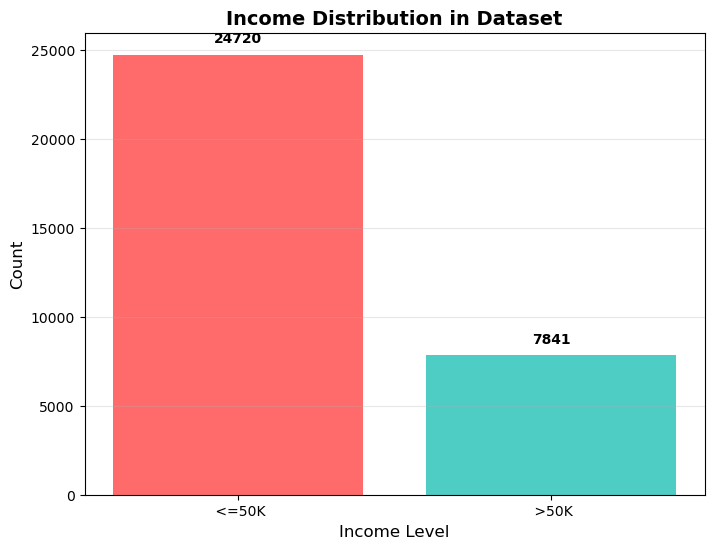

In [48]:
from IPython.display import Image, display

display(Image(url=result.analysis_graphs[0].url))

## Summary

- Use `dspy.DataFrame` as the type annotation for DataFrame input fields
- DataFrames are serialized via Parquet, preserving all dtypes
- Rich metadata (shape, columns, dtypes, samples) is provided to the LLM
- The DataFrame is available in the RLM sandbox for pandas operations
- Works seamlessly with other input types (strings, numbers, etc.)